# Demo RNA usando Auto-Keras para clasificar (atributo clase discreto) o estimar (atributo clase continuo)

Fuente: https://autokeras.com/

In [1]:
#@title Instalar Auto-Keras
#!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install keras-tuner --upgrade
!pip install autokeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.9 MB/s eta 0:00:00


In [2]:
#@title Librerías a usar
import autokeras as ak

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import csv


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [3]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [4]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [6]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 37
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 38

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 13
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 12


# Modelo:

In [7]:
#@title Establecer modelo base para AutoKeras

cantidad_intentos_encontrar_modelo = 10 #@param {type:"integer"}
if cantidad_intentos_encontrar_modelo < 1:
  cantidad_intentos_encontrar_modelo = 1


if esProblemaClasificacion:
  # AutoKeras siempre se usa salida softmax
  # (se puede usar salida lineal pero lo aplica el pipeline,
  #  no el modelo que se exporta)
  tipo_output_softMax = True

  # modelo para clasificación
  AKmodel = ak.AutoModel(
      inputs=ak.Input(),
      outputs=ak.ClassificationHead(num_classes=len(CLASES)),
      overwrite=True,
      max_trials=cantidad_intentos_encontrar_modelo
  )

else:
  # no debe ser softMax para estimación
  tipo_output_softMax = False

  # modelo para estimación
  AKmodel = ak.AutoModel(
      inputs=ak.Input(),
      outputs=ak.RegressionHead(),
      overwrite=True,
      max_trials=cantidad_intentos_encontrar_modelo
  )

print("Configuración para AutoKeras preparada: ", AKmodel)

Configuración para AutoKeras preparada:  <autokeras.auto_model.AutoModel object at 0x7a9e0a92b0a0>


4) Entrenar el modelo de la RNA:

In [8]:
#@title Entrenar con AutoKeras


max_epocas_entrenamiento =  100#@param {type:"integer"}
if max_epocas_entrenamiento <= 0:
  max_epocas_entrenamiento = None

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train,
                                       (y_trainEnc if tipo_output_softMax else y_train),
                                       test_size=0.1, shuffle=True)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# el history sólo devuelve el del último trial
#history =
AKmodel.fit(x_t, y_t,
                      validation_data=(x_v, y_v,),
                      epochs=max_epocas_entrenamiento
                      )

print("\n>Entrenamiento Finalizado.")


Trial 10 Complete [00h 00m 06s]
val_loss: 0.004470280837267637

Best val_loss So Far: 0.0009744713897816837
Total elapsed time: 00h 01m 24s
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3973 - loss: 1.4813 - val_accuracy: 0.5000 - val_loss: 1.0334
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4238 - loss: 1.1213 - val_accuracy: 0.6667 - val_loss: 0.7145
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6889 - loss: 0.6552 - val_accuracy: 1.0000 - val_loss: 0.3498
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8805 - loss: 0.4607 - val_accuracy: 0.7500 - val_loss: 0.3690
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7688 - loss: 0.4311 - val_accuracy: 1.0000 - val_loss: 0.1639
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9600 - loss: 0.2808 - val_accuracy: 0.9167 - val_loss: 0.2113
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9137 - loss: 0.2716 - val_accuracy: 1.0000 - 

In [9]:
 #@title Mostrar Resumen de las Pruebas realizadas por AutoKeras
 print(AKmodel.tuner.results_summary())

resEval = AKmodel.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Mejor Modelo con datos de Prueba: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
general_block_1/dense_block_1/use_batchnorm: False
general_block_1/dense_block_1/num_layers: 2
general_block_1/dense_block_1/units_0: 32
general_block_1/dense_block_1/dropout: 0.0
general_block_1/dense_block_1/units_1: 128
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.01
Score: 0.0009744713897816837

Trial 05 summary
Hyperparameters:
general_block_1/dense_block_1/use_batchnorm: False
general_block_1/dense_block_1/num_layers: 2
general_block_1/dense_block_1/units_0: 32
general_block_1/dense_block_1/dropout: 0.0
general_block_1/dense_block_1/units_1: 128
classification_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.01
Score: 0.0023836528416723013

Trial 06 summary
Hyperparameters:
general_block_1/dense_block_1/use_batchnorm: False
general_block_1/dense_block_1/num_layers: 2
general_block_1/dense_block_1/units_0: 32
general

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9545 - loss: 0.0901 

>Evaluación del Mejor Modelo con datos de Prueba: 
    - Error:  0.09582532197237015
    - Exactitud:  94.73684430122375




In [10]:
#@title Exportar Modelo y Re-Entrenar (opcional)

reentrenar_modelo = False #@param {type:"boolean"}

cant_epocas_reentrenamiento =  100#@param {type:"integer"}
if cant_epocas_reentrenamiento <= 0:
  cant_epocas_reentrenamiento = None


# exporta el modelo y lo muestra
print("\n>> Mejor modelo generado: ")
model = AKmodel.export_model()
model.summary()
print("")

if reentrenar_modelo:
  # realiza el re-entrenamiento del modelo
  print("\n\n>Comienza el Re-Entrenamiento:")
  history = model.fit(x_t, y_t,
                        validation_data=(x_v, y_v,),
                        epochs=cant_epocas_reentrenamiento
                        )
  print("\n>Re-Entrenamiento Finalizado.")


>> Mejor modelo generado: 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,900 (19.14 KB)

 Trainable params: 4,900 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

*** Resultados con datos de Entrenamiento: 
 Clase Real / Clase Modelo -> Resultado
  R: Virginica [3]  / M: Virginica [1.6385929e-08 3.5152232e-09 1.7961620e-03 9.9820381e-01] -> OK
  R: Virginica [3]  / M: Virginica [6.5603882e-07 2.2060469e-07 8.5952738e-03 9.9140388e-01] -> OK
  R: Setosa [1]  / M: Setosa [9.0011769e-11 9.9942410e-01 5.7590572e-04 5.8236543e-16] -> OK
  R: Versicolor [2]  / M: Versicolor [2.1883466e-06 6.7130319e-04 9.9919111e-01 1.3540937e-04] -> OK
  R: Setosa [1]  / M: Setosa [2.2441547e-12 9.9988824e-01 1.1166394e-04 2.1577769e-18] -> OK
  R: Versicolor [2]  / M: Versicolor [1.9779905e-06 3.1639789e-05 9.0848714e-01 9.1479331e-02] -> OK
  R: Virginica [3]  / M: Virginica [2.8805549e-09 1.7678105e-09 8.1185168e-03 9.9188143e-01] -> OK
  R: Versicolor [2]  / M: Versicolor [4.7850071e-06 6.3228882e-03 9.9364579e-01 2.6585138e-05] -> OK
  R: Versicolor [2]  / M: Versicolor [3.3876591e-07 8.7496330e-05 9.9953502e-01 3.7711693e-04] -> OK
  R: Setosa [1]  / M: Setosa 

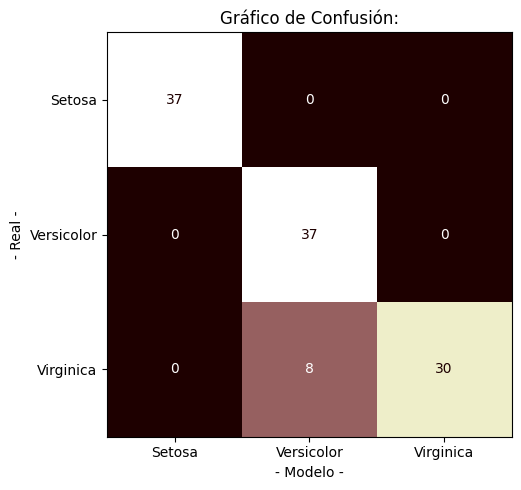

In [14]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo -> Resultado")
      else:
        print(" Clase Real / Clase Modelo -> Resultado")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ int(y[i]) ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) + ' [' + str(y[i]) + '] '
        strTitulo = strTitulo + ' / M: ' + str(clPred) + ' ' + str(predClass[i]) + ' '
        strTitulo = strTitulo + "-> " + ("OK" if (clPred==clReal) else "ERROR!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)


    # genera lista de labels
    labels_clases_map =  list(set(classReal + classPreds))
    labels_clases_map.sort()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in labels_clases_map],
        columns=['m:{:}'.format(x) for x in labels_clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    #cmtx.sort_index(axis=0, inplace=True)
    #cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:


>Evaluación del Modelo: 
    - Error:  0.096
    - Exactitud:  94.74


*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo -> Resultado
  [4.7 3.2 1.6 0.2]-> R: Setosa [1]  / M: Setosa [1.9331083e-10 9.9923778e-01 7.6229178e-04 1.9790891e-15] -> OK
  [5.1 3.8 1.6 0.2]-> R: Setosa [1]  / M: Setosa [3.4278212e-12 9.9987149e-01 1.2856357e-04 4.2713369e-18] -> OK
  [6.  2.7 5.1 1.6]-> R: Versicolor [2]  / M: Virginica [1.0417360e-06 1.5910471e-06 1.4657342e-01 8.5342395e-01] -> ERROR!
  [5.  3.4 1.5 0.2]-> R: Setosa [1]  / M: Setosa [2.1250382e-11 9.9971366e-01 2.8637261e-04 6.6477482e-17] -> OK
  [4.6 3.1 1.5 0.2]-> R: Setosa [1]  / M: Setosa [2.5566979e-10 9.9921542e-01 7.8456994e-04 2.9568895e-15] -> OK
  [5.5 2.5 4.  1.3]-> R: Versicolor [2]  / M: Versicolor [3.0745314e-06 2.4715040e-04 9.9833995e-01 1.4097787e-03] -> OK
  [5.  3.2 1.2 0.2]-> R: Setosa [1]  / M: Setosa [1.4809454e-11 9.9978209e-01 2.1783789e-04 3.6619193e-17] -> OK
  [5.7 3.8 1.7 0.3]-> R

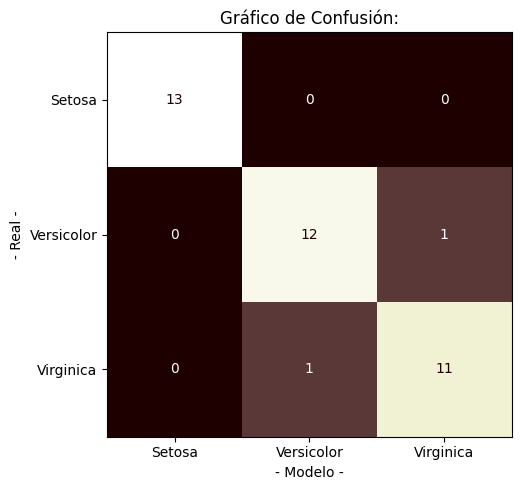

In [12]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))

#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [13]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosAUTOKERAS'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      import joblib
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", path_modelo,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosAUTOKERAS/model.keras 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosAUTOKERAS 

